# MA934 - class 4

## Deadline: 12:00 noon on Thursday 3 November 

You should make at least one commit to your repository per computational task below - usually more.

For this assignment, you must create a new Jupyter notebook called MA934_Class4_UniID.ipynb to contain the implementations that you write. You can separate out individual tasks if you prefer, but the full submission should be made as a single .zip via [our website](https://warwick.ac.uk/fac/sci/mathsys/courses/msc/ma934/resources/assessedwork/ma934declaration). The platform will not allow you to upload more than one file.

A few tips:
- please make sure to debug intermediate outputs as you code along. You are welcome to design smaller test cases and toy problems to verify your work (even if they are not part of the final submission).
- consider possible forms of input or arguments and make sure your solution can cope with *interesting* cases.
- do not forget to comment your code and use Markdown cells to explain what you are doing. A perfectly functional solution with no information about the thought process will not receive more than a subset of the points (~$70\%$ depending on the difficulty of the problem and how transparent the algorithm flow is). 
- generally getting used to writing tidy solution is good practice. Feel free to use [online resources](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet) for editing guidance.

## Task 1 - Solving a simple linear programme

In [1]:
# Import libraries
import time
import numpy as np
from numpy import linalg as la
import random
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

Vertices $(x_1, x_2)$ are found by finding the points of intersections between those lines which intersect

In [2]:
vertices = np.array([[6,28],[24,22],[228/7,70-2*228/7],[12,10]])
print(vertices)

[[ 6.         28.        ]
 [24.         22.        ]
 [32.57142857  4.85714286]
 [12.         10.        ]]


Plotting the search space. The feasible set is defined as the paralellogram whose vertices are black dots 

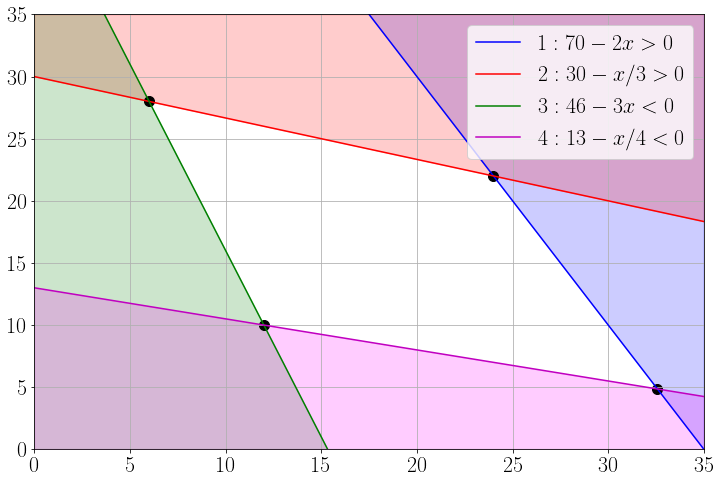

In [3]:
# reasonable search space for x1 is (0,35) from constraint 1
x = np.arange(0.0, 35.01, 0.1)

# defining functions returning the four constraints in terms of x2
def f1(inputlist):
    return [70.0 - 2.0*i for i in inputlist]

def f2(inputlist):
    return [30.0 - i/3.0 for i in inputlist]

def f3(inputlist):
    return [46.0 - 3.0*i for i in inputlist]

def f4(inputlist):
    return [13.0 - i/4.0 for i in inputlist]


# Plot inequalities
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12, 8))

plt.plot(x, f1(x), "b-", label = "$1: 70-2x>0$")
plt.fill_between(x, f1(x), 35.0, color='blue', alpha=.2)

plt.plot(x, f2(x), "r-", label = "$2: 30-x/3>0$")
plt.fill_between(x, f2(x), 35.0, color='red', alpha=.2)

plt.plot(x, f3(x), "g-", label = "$3: 46-3x<0$")
plt.fill_between(x, 0.0, f3(x), color='green', alpha=.2)

plt.plot(x, f4(x), "m-", label = "$4: 13-x/4<0$")
plt.fill_between(x, 0.0, f4(x), color='magenta', alpha=.2)

# points of intersection encompassing paralellogram
plt.scatter(vertices[:,0], vertices[:,1], color='k', s=100)

plt.legend(loc="upper right")

plt.xlim([0.0, 35.0])
plt.ylim([0.0, 35.0])

plt.grid()
plt.show()

Checking the cost function evaluated at the vertices

In [4]:
def cost(x1,x2): # cost function we aim to minimize
    return -40*x1 - 60*x2

In [5]:
for k in range(4):
    print('x1 = %.1f' % vertices[k,0])
    print('x2 = %.1f' % vertices[k,1])
    print('Cost: %.1f' % cost(vertices[k,0],vertices[k,1]))
    print('\n')

x1 = 6.0
x2 = 28.0
Cost: -1920.0


x1 = 24.0
x2 = 22.0
Cost: -2280.0


x1 = 32.6
x2 = 4.9
Cost: -1594.3


x1 = 12.0
x2 = 10.0
Cost: -1080.0




Our solution is therefore $(x_1, x_2) = (24,22)$

## Task 2 - Dantzig simplex algorithm

Write the above problem in standard form. Find a basic feasible vector in $\mathbb{R}^6$ with $x_1 = 12$ and $x_2 = 10$.

Write a code in Python that implements the Dantzig simplex algorithm in its simplest form.

Start your code from the basic feasible vector that you found above and write down the sequence of basic feasible vectors leading to the solution you found previously.

Introducing slack variables $\{s_1, s_2, s_3, s_4\}$, we write the problem as follows:

$$\min_{\substack{(x_1, x_2) \in \mathbb{R}^2} } -40\, x_1 - 60\, x_2$$

subject to the constraints

$$\begin{align*}
2 x_1 + x_2 + s_1 &= 70 \\
x_1 + 3 x_2 + s_2 &= 90 \\
-3 x_1 - x_2 + s_3 &= -46 \\
-x_1 - 4 x_2 + s_4 &= -52
\end{align*}$$

In standard form we are solving:

$$\min_{\substack{\mathbf{x} \in \mathbb{R}^6} } f(\mathbf{x}) = \mathbf{c}\cdot\,\mathbf{x}$$

where

$$\mathbf{c} = 
\begin{pmatrix}
-40 & -60 & 0 & 0 & 0 & 0
\end{pmatrix}$$

subject to 4 equality constraints, represented in matrix form

$$A \mathbf{x} = \mathbf{b}$$

with

$$A = 
\begin{pmatrix}
2 & 1 & 1 & 0 & 0 & 0 \\
1 & 3 & 0 & 1 & 0 & 0 \\
-3 & -1 & 0 & 0 & 1 & 0 \\
-1 & -4 & 0 & 0 & 0 & 1 
\end{pmatrix}$$

$$\mathbf{x} = \begin{pmatrix}
x_1 \\
x_2 \\
s_1 \\
s_2 \\
s_3 \\
s_4
\end{pmatrix}$$

and

$$\mathbf{b} = \begin{pmatrix}
70 \\
90 \\
-46 \\
-52
\end{pmatrix}$$

and $n$ non-negativity conditions
$$
x_1,x_2,s_1,s_2,s_3,s_4 \geq 0 .
$$

Finding a feasible vector in $\mathbb{R}^6$

In [106]:
x1 = 12
x2 = 10

#Solving backwards for s_i's
s1 = 70 - 2*x1 - x2
s2 = 90 - x1 - 3*x2
s3 = 3*x1 + x2 - 46
s4 = x1 + 4*x2 - 52

x_bfv = np.array([x1,x2,s1,s2,s3,s4])
print(x_bfv)

[12 10 36 48  0  0]


Dantzig simplex algorithm

In [107]:
# inputs
A = np.array([[2,1,1,0,0,0],[1,3,0,1,0,0],[-3,-1,0,0,1,0],[-1,-4,0,0,0,1]])
c = np.array([-40,-60,0,0,0,0])
b = A@x_bfv

In [108]:
# get indices of basic and non-basic variables and splitting A,c and basic feasible vector accordingly
idx_nonbasic = np.where(x_bfv == 0)[0]
idx_basic = np.nonzero(x_bfv)[0]
x_nonbasic = x_bfv[idx_nonbasic]
x_basic = x_bfv[idx_basic]
A_basic = A[:,:idx_nonbasic[0]]
A_nonbasic = A[:,idx_nonbasic[0]:]
Ainv_basic = la.inv(A_basic)
c_basic = c[:idx_nonbasic[0]]
c_nonbasic = c[idx_nonbasic[0]:]
obj_cost = c_basic@x_basic

N_nb = len(x_nonbasic)
N_b = len(x_basic)

# required inputs for revised simplex method
p = la.solve(A_basic,b)
Q = la.solve(A_basic,A_nonbasic)

In [109]:
# revised simplex method
red_costs = c_nonbasic - c_basic@Ainv_basic@A_nonbasic
print(red_costs)
z0 = c_basic@p
print(z0)

# get index to non-basic variable to make basic
gradf_nb = np.zeros((N_nb))

for i in range(N_nb):
    gradf_nb[i] = c[idx_nonbasic[i]] - c_basic@la.solve(A_basic,A[:,idx_nonbasic[i]])

chosenidx_nb = idx_nonbasic[np.argmin(gradf_nb)]
z_q = gradf_nb[chosenidx_nb]

# get index to basic variable to make non-basic
# w == column generation
w = la.solve(A_basic,A[:,chosenidx_nb])
xk = np.ones(N_b)*1e4

for j in range(N_b):
    if w[j] >= 0:
        xk[j] = x_basic[j]/w[j]

chosenidx_b = idx_basic[np.argmin(xk)]
# stepsize
alpha = xk[chosenidx_b]

# row reductions
# w
#RR1 = 1/w[chosenidx_b]
#w = w*RR1
#RR2 = np.zeros(N_b)
#for k in range(N_b):
#    if k != chosenidx_b:
#        RR2[k] = w[k]
#w -= RR2

# Ainv_basic
#Ainv_basic[chosenidx_b,:] = Ainv_basic[chosenidx_b,:]*RR1
#for k in range(N_b):
#    Ainv_basic[:,k] -= RR2

# p
#p[chosenidx_b] = p[chosenidx_b]*RR1
#p -= RR2
    
# swapping the non-basic and basic variables
#x_bfv[chosenidx_b] = xk[chosenidx_b]
x_basic -= alpha*w
obj_cost += alpha*z_q



#swapping columns of A and c
#A[:,[chosenidx_nb, chosenidx_b]] = A[:,[chosenidx_b, chosenidx_nb]]
#c[[chosenidx_nb, chosenidx_b]] = c[[chosenidx_b, chosenidx_nb]]

#print(p)

[ -9.09090909 -12.72727273]
-1080.0
[11.875 10.375 35.875 66.   ]


In [26]:
x_bfv = np.array([x1,x2,s1,s2,s3,s4])
A = np.array([[2,1,1,0,0,0],[1,3,0,1,0,0],[-3,-1,0,0,1,0],[-1,-4,0,0,0,1]])
c = np.array([-40,-60,0,0,0,0])
b = A@x_bfv

for l in range(25):
    # get indices of basic and non-basic variables and splitting A,c and basic feasible vector accordingly
    idx_nonbasic = np.where(x_bfv == 0)[0]
    idx_basic = np.nonzero(x_bfv)[0]
    x_nonbasic = x_bfv[idx_nonbasic]
    x_basic = x_bfv[idx_basic]
    A_basic = A[:,:idx_nonbasic[0]]
    c_basic = c[:idx_nonbasic[0]]
    print('idx_nonbasic: ',idx_nonbasic)
    print('idx_basic: ',idx_basic)
    print('x_nonbasic: ',x_nonbasic)
    print('x_basic: ',x_basic)
    print('A_basic: ',A_basic)
    print('c_basic: ',c_basic)

    N_nb = len(x_nonbasic)
    N_b = len(x_basic)

    # get index to non-basic variable to make basic
    gradf_nb = np.zeros((N_nb))

    for i in range(N_nb):
        gradf_nb[i] = c[idx_nonbasic[i]] - c_basic@la.solve(A_basic,A[:,idx_nonbasic[i]])
    
    print('gradf_nb: ',gradf_nb)
    chosenidx_nb = idx_nonbasic[np.argmin(gradf_nb)]
    print('chosenidx_nb: ',chosenidx_nb)

    # get index to basic variable to make non-basic
    w = la.solve(A_basic,A[:,chosenidx_nb])
    print('w: ',w)
    xk = np.ones(N_b)*1e4

    for j in range(N_b):
        if w[j] >= 0:
            xk[j] = x_basic[j]/w[j]
    
    print('xk: ',xk)
    chosenidx_b = idx_basic[np.argmin(xk)]

    # swapping the non-basic and basic variables
    x_bfv[chosenidx_b] = xk[chosenidx_b]

    #swapping columns of A and c
    A[:,[chosenidx_nb, chosenidx_b]] = A[:,[chosenidx_b, chosenidx_nb]]
    c[[chosenidx_nb, chosenidx_b]] = c[[chosenidx_b, chosenidx_nb]]

    print(x_bfv)
    print('\n')

idx_nonbasic:  [4 5]
idx_basic:  [0 1 2 3]
x_nonbasic:  [0 0]
x_basic:  [12 10 36 48]
A_basic:  [[ 2  1  1  0]
 [ 1  3  0  1]
 [-3 -1  0  0]
 [-1 -4  0  0]]
c_basic:  [-40 -60   0   0]
gradf_nb:  [ -9.09090909 -12.72727273]
chosenidx_nb:  5
w:  [ 0.09090909 -0.27272727  0.09090909  0.72727273]
xk:  [  132. 10000.   396.    66.]
[12 10 36 66  0  0]


idx_nonbasic:  [4 5]
idx_basic:  [0 1 2 3]
x_nonbasic:  [0 0]
x_basic:  [12 10 36 66]
A_basic:  [[ 2  1  1  0]
 [ 1  3  0  0]
 [-3 -1  0  0]
 [-1 -4  0  1]]
c_basic:  [-40 -60   0   0]
gradf_nb:  [-7.5 17.5]
chosenidx_nb:  4
w:  [-0.375  0.125  0.625  0.125]
xk:  [10000.     80.     57.6   528. ]
[12 10 57 66  0  0]


idx_nonbasic:  [4 5]
idx_basic:  [0 1 2 3]
x_nonbasic:  [0 0]
x_basic:  [12 10 57 66]
A_basic:  [[ 2  1  0  0]
 [ 1  3  0  0]
 [-3 -1  1  0]
 [-1 -4  0  1]]
c_basic:  [-40 -60   0   0]
gradf_nb:  [12. 16.]
chosenidx_nb:  4
w:  [ 0.6 -0.2  1.6 -0.2]
xk:  [   20.    10000.       35.625 10000.   ]
[20 10 57 66  0  0]


idx_nonbas

## Task 3 - Gradient descent

Consider the following optimisation problem in $\mathbb{R}^n$

$$\min_{\substack{\mathbf{x} \in \mathbb{R}^n} } f(\mathbf{x})$$

where $f(\mathbf{x})$ is the quartic function defined as

$$ f(\mathbf{x}) = \frac{1}{4} \left( (\mathbf{x} - \mathbf{x}_*)^T A\cdot (\mathbf{x} - \mathbf{x}_*)\right)^2 $$

with 

$$ A = \left( 
\begin{array}{ccccc} 
\frac{\lambda+1}{2} & \frac{\lambda - 1}{2} & 0 &\ldots & 0\\ 
\frac{\lambda-1}{2} & \frac{\lambda + 1}{2} & 0 &\ldots & 0\\
0 & 0 & 1 &\ldots & 0\\ 
\vdots & \vdots & \vdots &\ddots & \vdots\\ 
0 & 0 & 0 &\ldots & 1
\end{array}
\right),
$$
$$
\mathbf{x}_* = \left( \begin{array}{c}
\sqrt{2}\\
\sqrt{3}\\
1\\
\vdots\\
1
\end{array}
\right)
$$
and $\lambda > 0$ is a parameter that controls the shape of the objective function. A reasonable range of values for $\lambda$ is $\frac{1}{10} \leq \lambda \leq 10$.

* Write down the solution of this problem.
* Write down the eigenvalues of the matrix $A$.
* Derive a formula for the gradient, $\nabla f(\mathbf{x})$, at any point in $\mathbb{R}^n$.
* Use your results to implement the gradient descent algorithm in Python. Use your algorithm to numerically solve the above problem with $n=2$ and $\lambda=2$. A good initial point is $\mathbf{x}_0 = 5\,\mathbf{x}_*$.  A good tolerance is $\varepsilon = 10\, \epsilon_m$. **Note:** You will need to write your own *Golden Section Search* code as part of this task, which is a small subproblem in itself. Make sure you verify your implementation with smaller datasets before deploying it within the context of the larger problem.
* Plot how the distance from the minimum decreases as s function of the number of iterations and empirically determine the convergence rate of the algorithm.
* Determine empirically how the number of steps required to solve the problem varies with $\lambda$ when $n=3$.

*Write down the solution of this problem*

$$\mathbf{x} = \mathbf{x}_\star$$

*Write down the eigenvalues of the matrix $A$*

$$|A - \kappa I_n| = \big{(}\frac{\lambda+1}{2} - \kappa\big{)}\big{(}\frac{\lambda+1}{2} - \kappa\big{)}(1-\kappa)...(1-\kappa) - \big{(}\frac{\lambda+1}{2}\big{)}^2(1-\kappa)...(1-\kappa) = 0$$

$$\implies (1-\kappa)...(1-\kappa)(\lambda - (\lambda+1)\kappa + \kappa^2) = 0$$

$$\implies \kappa = 1, \; \frac{\lambda+1\pm\sqrt{(\lambda-1)^2}}{2}$$

$$\implies \kappa = 1, \; \lambda$$

*Derive a formula for the gradient, $\nabla f(\mathbf{x})$, at any point in $\mathbb{R}^n$.*

Letting

$$\mathbf{r = x - x_\star}$$

We compute the matrix derivative using the Chain Rule

*Use your results to implement the gradient descent algorithm in Python. Use your algorithm to numerically solve the above problem with $n=2$ and $\lambda=2$. A good initial point is $\mathbf{x}_0 = 5\,\mathbf{x}_\star$.  A good tolerance is $\varepsilon = 10\, \epsilon_m$. **Note:** You will need to write your own Golden Section Search code as part of this task, which is a small subproblem in itself. Make sure you verify your implementation with smaller datasets before deploying it within the context of the larger problem*

In [94]:
# inputs
n = 2
lamb = 2
eps = 1e-15

# fixed point
xstar = np.ones(n)
xstar[0] = np.sqrt(2.0)
xstar[1] = np.sqrt(3.0)

# matrix
A = np.zeros((n,n))
A[0,0] = (lamb+1)/2
A[1,1] = (lamb+1)/2
A[0,1] = (lamb-1)/2
A[1,0] = (lamb-1)/2

# quartic function to be minimised and its corresponding gradient
def f(x):
    global A, xstar
    r = x-xstar
    return 0.25*(np.transpose(r)@A@r)**2

def df(x):
    global A, xstar
    r = x-xstar
    return (np.transpose(r)@A@r)*(A@r)

Custom Golden Search algorithm which will be needed to perform line minimisation

In [95]:
def GoldenSearch(f, interval, tol):
    # function which searches for minimum of f(x) via a bracketing-and-bisection method
    # triple = (a c b) must bracket the minimum such that f(c) < f(a) and f(c) < f(b)
    # if maximum required enter -f as function
    
    [a, b] = interval
    w = (np.sqrt(5)-1)/2
    # choosing c (makes (c, b) the larger interval)
    c = (b + w*a)/(1 + w)
    
    # perform search until interval length falls below specified tolerance
    while b - a > tol:
        
        # case (c, b) is the larger interval
        if np.abs(b - c) > np.abs(c - a):
            x = c + (1 - w)*(b - c)
            if f(c) < f(x):
                [a, c, b] = [a, c, x] # case 1A: c bracketed by (a, x)
            else:
                [a, c, b] = [c, x, b] # case 1B: x bracketed by (c, b)
                
        # case (a, c) is the larger interval        
        else:
            x = c - (1 - w)*(c - a)
            if f(c) < f(x):
                [a, c, b] = [x, c, b] # case 2A: c bracketed by (x, b)
            else:
                [a, c, b] = [a, x, c] # case 2B: x bracketed by (a, c)
  
    
    return c

We now perform the gradient descent

In [96]:
def gradient_descent(f, df, x0, tol, track_convergence=False):
    # function designed to find the __minimum__ of f(x) taking x in R^n using method of steepest descent
    # f: function to be minimised
    # df: gradient of f
    # x0: initial starting point
    # tol: tolerance required for convergence
    # track_convergence: if true we will keep track of the norm of df at each iteration
    
    xn = x0 # initial guess
    vn = -df(xn)/la.norm(df(xn)) # position vector
    guesses = xn # matrix which will store xn at each iteration
    
    # function which allows to find the line minimisation of f when implemented into Golden Search
    def line_minimiser(lamb):
        return f(xn + lamb*vn)
    
    while la.norm(df(xn)) > eps:
        #perform line minimisation using Golden Search
        lamb_min = GoldenSearch(line_minimiser, [0,10], 1e-10)
        
        #updating xn in direction of steepest descent
        xn = xn + lamb_min*vn
        
        #updating vn
        vn = -df(xn)/la.norm(df(xn))
        
        # stacking guesses vertically with our current estimation for xn
        if track_convergence == True:
            guesses = np.vstack((guesses,xn))

    
    if track_convergence == True:
        return guesses
    
    else:
        return xn

In [97]:
gradient_descent(f, df, 5*xstar, eps, False)

array([1.41421304, 1.7320513 ])

Plot how the distance from the minimum decreases as a function of the number of iterations and empirically determine the convergence rate of the algorithm.

In [98]:
x_guesses = gradient_descent(f, df, 5*xstar, eps, True)
N_iter = np.shape(x_guesses)[0]
rs = x_guesses - xstar*np.ones(np.shape(x_guesses))
                               
distances = np.zeros(N_iter)
for i in range(N_iter):
    distances[i] = la.norm(rs[i,0])
print(distances)

[5.65685425e+00 3.25449112e-01 7.17034793e-03 4.12523981e-04
 9.08877310e-06 5.22923060e-07]


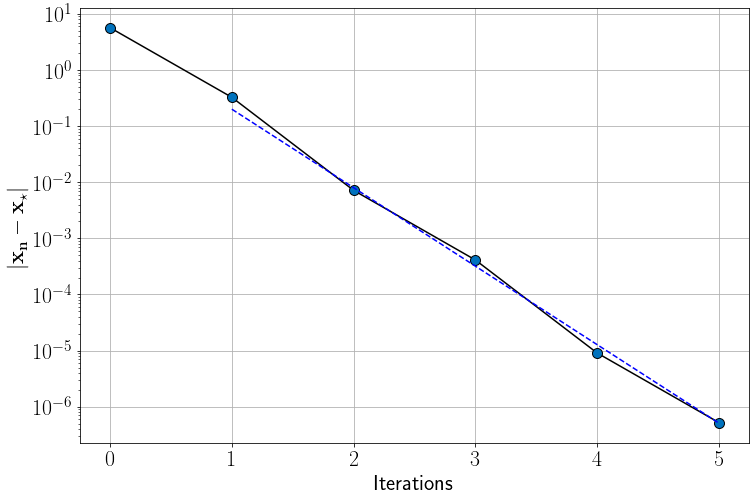

In [99]:
#plotting
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12, 8))
c = 0.04
plt.plot(range(N_iter), distances, '-ko', markersize=10, markerfacecolor=(0, 0.447, 0.741, 1))
plt.plot(range(1,N_iter), [5*c**i for i in range(1,N_iter)], '--b')

#plt.legend(loc="upper left")

plt.xlabel(r"Iterations")
plt.ylabel(r"$|\mathbf{x_n - x_\star}|$")
plt.yscale("log")
plt.grid()
plt.show()

Determine empirically how the number of steps required to solve the problem varies with $\lambda$ when $n=3$

In [100]:
# inputs
n = 3

# fixed point
xstar = np.ones(n)
xstar[0] = np.sqrt(2.0)
xstar[1] = np.sqrt(3.0)

# matrix
A = np.zeros((n,n))
A[-1,-1] = 1

In [101]:
lambs = np.arange(0.1,10.1,0.1)
no_steps = np.zeros(len(lambs))

for i in range(len(lambs)):
    lamb = lambs[i]
    A[0,0] = (lamb+1)/2
    A[1,1] = (lamb+1)/2
    A[0,1] = (lamb-1)/2
    A[1,0] = (lamb-1)/2

    no_steps[i] = np.shape(gradient_descent(f, df, 5*xstar, eps, True))[0]

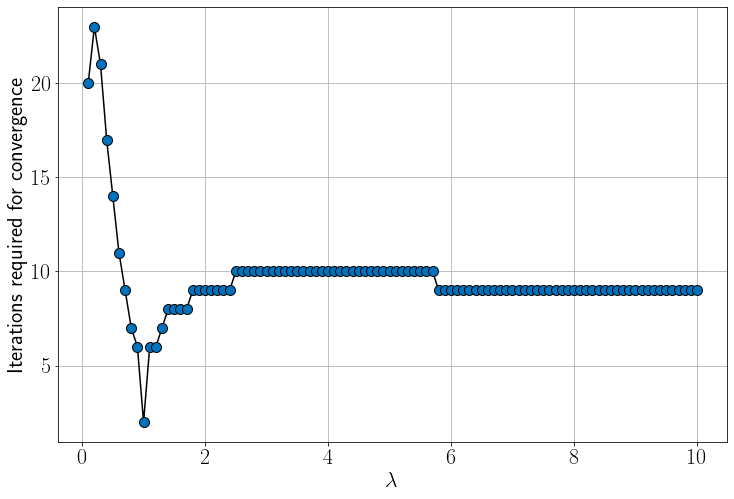

In [102]:
#plotting
plt.figure(figsize=(12, 8))

plt.plot(lambs, no_steps, '-ko', markersize=10, markerfacecolor=(0, 0.447, 0.741, 1))
#plt.plot(range(1,N_iter), [5*c**i for i in range(1,N_iter)], '--b')

#plt.legend(loc="upper left")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"Iterations required for convergence")
#plt.yscale("log")
plt.grid()
plt.show()

## Task 4 - Stochastic gradient descent

Consider the following linear model expressing a noisy relationship between a target variable, $y \in \mathbb{R}$ and a set of predictor variables, $\mathbf{x} \in \mathbb{R}^n$:

$$ y = \mathbf{\alpha}^T \, \mathbf{x} + \xi $$

where $\mathbf{\alpha} \in \mathbb{R}^n$ is a set of parameters and $\xi \sim N(0, \sigma^2)$ is a normal random variable with mean 0 and variance $\sigma^2$ representing the error. We are given a set of $m$ observations

$$Y = \left\{(\mathbf{x}^{(i)},\, y^{(i)})\ : i=1\ldots m \right\}$$

Our task is to find the "best" set of parameters, $\mathbf{\alpha}_*$ given the observations by solving the ordinary least squares problem:

$$\mathbf{\alpha}_* = \min_{\substack{\mathbf{\alpha} \in \mathbb{R}^n} } F(\mathbf{\alpha}\, |\, Y)$$

where

$$ F(\mathbf{\alpha}\, |\, Y) = \frac{1}{2}\, \frac{1}{m} \sum_{i=1}^m\left( y^{(i)} - \mathbf{\alpha}^T\,\mathbf{x}^{(i)}\right)^2$$

Create a test problem with the following specifications (obviously you can vary the parameters):

```
n=10
m=100
xmax = 10.0
sigma = 0.25
```

* Solve the problem using the gradient descent code you have written above. Due to the noise, you should not expect to recover the exact "true" value of $\alpha_*$ used to generate the test data but you should be close if the noise is not too large.
* Modify your code to do the optimisation using stochastic gradient descent and compare the results graphically.
* Fix $n=10$ and $m=250$. Compare the performance of your stochastic gradient descent algorithm with different learning rates. Can you find one that performs well?

**Hint:** for both Task 3 and Task 4 you may wish to consult [the provided resources](https://warwick.summon.serialssolutions.com/#!/search/document?ho=t&include.ft.matches=f&fvf=ContentType,Newspaper%20Article,t%7CContentType,Book%20Review,t&l=en-UK&q=Understanding%20Machine%20Learning:%20From%20Theory%20to%20Algorithms&id=FETCHMERGED-warwick_catalog_b279036183) on the module webpage, as well as [nicely explained tutorials](https://realpython.com/gradient-descent-algorithm-python/) on the subject matter. This will help you craft your own code and specialise it for the problems at hand.